In [12]:
#156.11assignment.py
# This code was written in collboration with 
#Yoel, Skye, and group members of CS156 Facebook chat.
import glob
import os
import numpy as np
from astropy.table import Table, Column

## Part 1:

In [11]:
### This function reads the data.

def upload_files(your_path):
    file_list = glob.glob(os.path.join(os.getcwd(), your_path))
    
    corpus_name =[]
    
    for file_path in file_list:
        with open(file_path) as f_input:
            corpus_name.append(f_input.read())
    return corpus_name

In [3]:
#Here I open my data and split into language train sets and test set.
#notice the location of the folders on your computer!
train_corpus = upload_files("symbol/language-training*")
test_corpus = upload_files("symbol/language-test*")

data_input_A = train_corpus[:30]
data_input_B = train_corpus[30:60]
data_input_C = train_corpus[60:]

In [67]:
def MarkovChain(data_input):
    #"Using python, build a Markov model for each of the languages."
    #This function takes in a training 
    #corpus and outputs a table transition matrix for that language
    #stores count of how many times 
    #letter i has been followed by letter j in nested loop
    #then normalizes those values to set as probabilities

    # this pulls out the list of our symbols in the data
    letters = list(set(data_input[2])) 
    # initializes empty matrix
    prob_matrix = np.zeros((len(letters),len(letters)))  
    
    for s in range(len(data_input)):
        for ind in range(len(data_input[s])-1):
            for i in range(len(letters)):
                if data_input[s][ind] == letters[i]:
                    for j in range(len(letters)):
                        if data_input[s][ind+1] == letters[j]:
                            prob_matrix[i][j] +=1
    
    #normalizes the matrix:
    prob_matrix = prob_matrix / prob_matrix.sum(axis=1)[:,None]
    Markov_Model = Table(prob_matrix, names = letters) #makes a pretty table
    return Markov_Model #returns the table


MarkovChain(data_input_A)

A,e,g,k,o,p,t
float64,float64,float64,float64,float64,float64,float64
0.183970856102,0.0564663023679,0.220400728597,0.0418943533698,0.216757741348,0.0437158469945,0.23679417122
0.0219224283305,0.185497470489,0.20741989882,0.035413153457,0.251264755481,0.0590219224283,0.239460370995
0.294117647059,0.259259259259,0.276688453159,0.0305010893246,0.0457516339869,0.0152505446623,0.078431372549
0.0486486486486,0.0378378378378,0.0864864864865,0.52972972973,0.108108108108,0.0972972972973,0.0918918918919
0.304435483871,0.306451612903,0.0443548387097,0.0221774193548,0.25,0.0241935483871,0.0483870967742
0.0346534653465,0.10396039604,0.113861386139,0.049504950495,0.113861386139,0.465346534653,0.118811881188
0.267489711934,0.32304526749,0.0555555555556,0.0185185185185,0.0720164609053,0.022633744856,0.240740740741


In [68]:
#This function returns the probability of a 
#particular state shift (from i to j) given
#a probability transition matrix for a language. 
#Note this is for one singular state change.

def prob_of_letter(i,j,Transition): #Reads transition 
    #matrix to return probability that state j comes after i
    
    letter_dict={}
    letters = ['A', 'e', 'g', 'k', 'o','p', 't']
    for w in range(len(letters)):
        letter_dict[letters[w]]= w
    return Transition[letter_dict[i]-1][letter_dict[j]-1]
    

## This function returns the probability of 
#a string given a language  by looping through the string
#and returning the product of all the probabilities of each transition

def prob_of_string_language(string,data_input_language):
    probs=[]
    for i in range(len(string)-1):
        probs.append(prob_of_letter(string[i],string[i+1],MarkovChain(data_input_language)))
        #print string[i], string[i+1], len(string), i+1
    prob_of_lang = np.prod(np.array(probs))
    return prob_of_lang

## this uses Bayes to calculate P(language|string) because P(language|str) 
#is proportional to P(str|language)
#P(language model) = 1/3 for all strings and P(str) is constant as well.
#P(language) and P(str) are the same for all languages given a string 
#so we can ignore them for classification
## then normalize the probabilities later to get 
#the true probabilities because they must sum to 1.

In [70]:
## Produce results:

classes = []
posteriors=[]

for i in range(len(test_corpus)):
    # probability that the ith string in test corpus is language A:
    p_A = prob_of_string_language(test_corpus[i], data_input_A)

    # probability that the ith string in test corpus is language B:
    p_B = prob_of_string_language(test_corpus[i], data_input_B)
    
    # probability that the ith string in test corpus is language B:
    p_C = prob_of_string_language(test_corpus[i], data_input_C)

    # construct classes list:
    if max(p_A,p_B,p_C) == p_A:
        classes.append('A')
    elif max(p_A,p_B,p_C) == p_B:
        classes.append('B')
    elif max(p_A,p_B,p_C) == p_C:
        classes.append('C')
    
    #construct posteriors list:
    p_sum = p_A + p_B + p_C
    posteriors.append((i,[p_A/p_sum,p_B/p_sum,p_C/p_sum]))
    
print 'test corpus classes are:', classes
print 'posteriors: ', posteriors

test corpus classes are: ['B', 'B', 'B', 'C', 'B', 'C', 'B', 'C', 'C', 'B']
posteriors:  [(0, [1.8820968256445955e-23, 0.99773015563263934, 0.0022698443673607239]), (1, [1.983285451706237e-06, 0.99267751060303477, 0.0073205061115135736]), (2, [1.7174082442274626e-08, 0.97236428248036078, 0.027635700345556694]), (3, [2.1121792914289608e-16, 0.016788337856251539, 0.98321166214374833]), (4, [3.7202187827210293e-07, 0.99999962313990898, 4.8382127733647256e-09]), (5, [0.014989848072646026, 2.1126625049776285e-21, 0.98501015192735397]), (6, [2.1584307033728302e-11, 0.99999991590289605, 8.4075519620014532e-08]), (7, [2.8512714218486112e-05, 9.2281792636093108e-22, 0.99997148728578156]), (8, [3.8721822874800726e-06, 9.8316490087838393e-22, 0.99999612781771252]), (9, [1.9200444644530564e-26, 0.99478362451315794, 0.0052163754868420715])]


## Part 2:

In [3]:
import nltk
import glob
import os
import re
import scipy.io.wavfile
import math
import numpy as np
from astropy.table import Table, Column

### Explanation of the model, and code of the initialization part:

In [37]:

phonemes = [['A', 'o', 'e', 't', 'p', 'g', 'k'],
['A', 'o', 'e', 't', 'p', 'g', 'k'],['A', 'o', 'e', 't', 'p', 'g', 'k'],
['A', 'o', 'e', 't', 'p', 'g', 'k'],['A', 'o', 'e', 't', 'p', 'g', 'k'],
['A', 'o', 'e', 't', 'p', 'g', 'k'],['A', 'o', 'e', 't', 'p', 'g', 'k']]

#initializing random emissions probabilities:
P_state_1_per_speaker = .3
emissions = {}
all_emissions = []
for i in range(3):
	name = "P_phonemes_emission_{}".format(i+1)
	# print name
	#nums here are samples from dirichlet that are 2d list:
	nums = np.random.dirichlet(np.ones(7),size=1)
	#flatten the list with sum:
	nums = sum(nums)
	# print nums, "sum to:" ,sum(nums) 
    #sanity check: all nums sum to one because they are derives 
    #from Dirichletm which is a pdf of pdfs, 
	#so sampling from it actually samples probabilites.
	emissions[name] = nums
	all_emissions.append(emissions[name])

"""
Transition Matrix: 
notice the uniform prioir for the two other speakers: 
no one is more aggresive than the other and so they are equally likely to 
cut the speaker.
"""
Speaker_1 = [.9,.05,.05]
Speaker_2 = [.05,.9,.05]
Speaker_3 = [.05,.05,.9]


transition_matrix = [Speaker_1, 
					 Speaker_2,
					 Speaker_3]

print "-------------------------------------------- transition matrix: ------------------------------"
print transition_matrix[0], '\n' ,transition_matrix[1], '\n' , transition_matrix[2]

print "-------------------------------------------- All sufficient data: ------------------------------"
# Couple phonemes with probabilites, and craete 
#a dict with speakers as keys for O(1) access:
speakers = ['Speaker_1','Speaker_2','Speaker_3']
t = 1
speakers_info = {}
for i,j,speaker in zip(all_emissions, phonemes, speakers):
	phonemes_probs = zip(i,j)
	print "Emission probabilities for speaker {} : \n".format(t),phonemes_probs, "\n"
	speakers_info[speaker] = phonemes_probs
	t+=1


# probability of 'everything', i.e. the joint probability of O,H:
# P(O,H) = P(H_1) \prod_t P(H_t | H_t-1) P(O_t | H_t)


print "----------------------------------------------- HMMModel: ------------------------------------"
print"""
Loading obsreved data and identifying 
probabilities of speakers per each phonem:
"""

PATH = "speaker.2*" #notice that the symbol file's 
#folder "symbol" should be in the same folder as this py file.
import os, glob
joined_files = glob.glob(os.path.join(os.getcwd(),PATH))

for each_file in joined_files:
	# open the file and read the text:
	with open(each_file) as f:
		text = f.read()
		#create a list of tuples with file name and the raw text:
		observed_data = text

# HMMModel:
# 1. Generage the random speaker:
import random
first_to_speak = random.choice(speakers_info.keys())

print """
The first speaker chosen is: {}. \n
The transition probabilites, and emission probabilities 
of the first state / speaker randomely chosen are: 
\n""".format(first_to_speak), speakers_info[first_to_speak]

# E. Given our parameters, can we compute how likely the hidden states are?
first_param = observed_data[0]
print "first parameter:", first_param
# P(first_to_speak, first_param) =
#P_state_1_per_speaker i.e. .33 * P(H_t | H_t-1) * P(O_t | H_t)
#since this is the first state, we don't need to 
#consider the state before (i.e. the transition would just be 1)

#prob_first_OandH = 
#P_state_1_per_speaker * [(num,_) for i in speakers_info[first_to_speak] if i is first_param]


print """
EM is an iterative algorithm. It works by computing an initial estimate for the
probabilities, then using those estimates to computing a better estimate, and so on,
iteratively improving the probabilities that it learns.
https://web.stanford.edu/~jurafsky/slp3/9.pdf
"""

-------------------------------------------- transition matrix: ------------------------------
[0.9, 0.05, 0.05] 
[0.05, 0.9, 0.05] 
[0.05, 0.05, 0.9]
-------------------------------------------- All sufficient data: ------------------------------
Emission probabilities for speaker 1 : 
[(0.14034702489309211, 'A'), (0.19906276573952217, 'o'), (0.30698416234334097, 'e'), (0.129385515085984, 't'), (0.15245712458951835, 'p'), (0.02161575655301555, 'g'), (0.050147650795526924, 'k')] 

Emission probabilities for speaker 2 : 
[(0.10988290847925104, 'A'), (0.32719556494921564, 'o'), (0.091358085709219508, 'e'), (0.16935170474266648, 't'), (0.091970018754579483, 'p'), (0.015380496669967146, 'g'), (0.19486122069510067, 'k')] 

Emission probabilities for speaker 3 : 
[(0.029102635428063885, 'A'), (0.33084252009064474, 'o'), (0.11511233232423151, 'e'), (0.046077317609007726, 't'), (0.45387840490868364, 'p'), (0.0062192767054857125, 'g'), (0.018767512933882759, 'k')] 

----------------------------

### Prediction of states using HMMLearn:

/Users/oba2311/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/oba2311/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/oba2311/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/oba2311/anaconda2/lib/python2.7/site

prediction: [2 0 2 2 2 2 2 1 2 2 2 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 2 1 1
 0 1 1 1 0 1 0 0 0 0 0 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0
 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 2 2 0 2 2 2 2 2 0 2 2 2 0 0 2 0 0 0 0 2 1
 0 1 0 0 1 0 1 0 1 0 0 0 1 2 2 2 1 2 2 2 2 0 0 0 0 1 1 1 1 0 0 2 2 2 2 2 0
 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 2 0 2 1 2 1 2 2 0 0 2 0 0 0 0 0
 2 2 2 2 0 1 1 1 1 2 1 0 2 2 2 0 2 0 2 2 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0
 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 2 2 0 0 0 0 1 0 1 0 0 1 1 0
 1 1 1 0 2 2 0 2 2 2 2 0 2 2 2 2 0 2 0 1 0 0 2 1 0 0 0 2 0 2 1 2 2 0 1 2 2
 0 0 1 0 0 1 1 2 1 1 0 0 0 0 0 1 0 0 1 2 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1
 0 0 1 1 1 1 2 1 2 0 2 0 2 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 0 1 0
 0 0 0 1 2 2 0 0 2 0 0 2 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2
 0 0 2 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0
 0 0 0 0 0 0 0 2 0 1 1 0 0 0 1 0 2 0 0 2 2 2 2 2 2 2 2 2 2 1 0 2 1 2 0 0 1
 0 1 0 0 2 0 

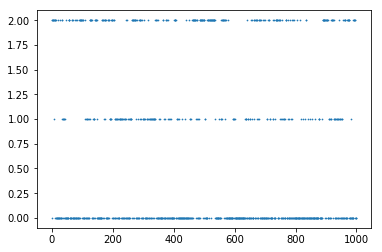

In [51]:
%matplotlib inline

PATH = "speaker.2*" #notice that the symbol 
#file's folder "symbol" should be in the same folder as this py file.
import os, glob
joined_files = glob.glob(os.path.join(os.getcwd(),PATH))

for each_file in joined_files:
	# open the file and read the text:
	with open(each_file) as f:
		text = f.read()
		#create a list of tuples with file name and the raw text:
		observed_data = text

#convert the string to nums:
chars_as_nums = []
for i in text:
	num = ord(i)
	chars_as_nums.append(num)

import numpy as np
X = np.asarray(chars_as_nums).reshape(-1,1)
import numpy as np
states = 'sp1','sp2','sp3'
SEQUENCE = (states,text)

from hmmlearn import hmm

#Using the HMM with the MAP algorithm: Maximum 
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100,algorithm="map")
#"MAP: maximum a posteriori probability 
#(MAP) estimate is an estimate of an unknown quantity, 
#that equals the mode of the posterior distribution. "
remodel.fit(X)  
#NOTICE: the model predicts the most likely speaker at a point, 
#but unfortunately not the posterior (i.e. the likelihood of each speaker,
#given the former step (transmission prob.) and the phoneme(emission prob.))
Z2 = remodel.predict(X)
import matplotlib.pyplot as plt
print 'prediction:' ,Z2
plt.plot(Z2,'o', markersize=.7)